In [295]:
import numpy as np
import pandas as pd
from data_reader import read_consumption_and_weather
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

In [296]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

Holes by length and occurrences in column NO3:
holes
1        1
dtype: int64
Filling holes up to length 3
Any remaining holes after interpolation? False


In [297]:
df1

,consumption,temperature
2017-05-01 00:00:00+00:00,3325.431995,2.200000
2017-05-01 01:00:00+00:00,3344.690998,3.200000
2017-05-01 02:00:00+00:00,3398.359002,4.000000
2017-05-01 03:00:00+00:00,3430.220001,3.600000
2017-05-01 04:00:00+00:00,3606.750000,3.400000
...,...,...
2023-01-21 19:00:00+00:00,5947.502808,-10.233333
2023-01-21 20:00:00+00:00,5868.196111,-11.266667
2023-01-21 21:00:00+00:00,5742.156776,-12.016667
2023-01-21 22:00:00+00:00,5653.673398,-12.083333


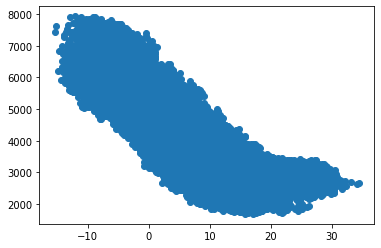

In [298]:
# Dataloaders
plt.scatter(df1['temperature'], df1['consumption'])

In [299]:
consumption = df1['consumption'].shift(periods=1, fill_value=0)

In [300]:
consumption

2017-05-01 00:00:00+00:00       0.000000
2017-05-01 01:00:00+00:00    3325.431995
2017-05-01 02:00:00+00:00    3344.690998
2017-05-01 03:00:00+00:00    3398.359002
2017-05-01 04:00:00+00:00    3430.220001
                                ...     
2023-01-21 19:00:00+00:00    5996.773735
2023-01-21 20:00:00+00:00    5947.502808
2023-01-21 21:00:00+00:00    5868.196111
2023-01-21 22:00:00+00:00    5742.156776
2023-01-21 23:00:00+00:00    5653.673398
Freq: H, Name: consumption, Length: 50208, dtype: float64

In [301]:
target = df1['consumption']
target

2017-05-01 00:00:00+00:00    3325.431995
2017-05-01 01:00:00+00:00    3344.690998
2017-05-01 02:00:00+00:00    3398.359002
2017-05-01 03:00:00+00:00    3430.220001
2017-05-01 04:00:00+00:00    3606.750000
                                ...     
2023-01-21 19:00:00+00:00    5947.502808
2023-01-21 20:00:00+00:00    5868.196111
2023-01-21 21:00:00+00:00    5742.156776
2023-01-21 22:00:00+00:00    5653.673398
2023-01-21 23:00:00+00:00    5523.002220
Freq: H, Name: consumption, Length: 50208, dtype: float64

In [302]:
temp = df1['temperature'].shift(periods=1, fill_value=0)
temp

2017-05-01 00:00:00+00:00     0.000000
2017-05-01 01:00:00+00:00     2.200000
2017-05-01 02:00:00+00:00     3.200000
2017-05-01 03:00:00+00:00     4.000000
2017-05-01 04:00:00+00:00     3.600000
                               ...    
2023-01-21 19:00:00+00:00    -9.800000
2023-01-21 20:00:00+00:00   -10.233333
2023-01-21 21:00:00+00:00   -11.266667
2023-01-21 22:00:00+00:00   -12.016667
2023-01-21 23:00:00+00:00   -12.083333
Freq: H, Name: temperature, Length: 50208, dtype: float64

In [303]:
temp_forecast = df1['temperature']
temp_forecast

2017-05-01 00:00:00+00:00     2.200000
2017-05-01 01:00:00+00:00     3.200000
2017-05-01 02:00:00+00:00     4.000000
2017-05-01 03:00:00+00:00     3.600000
2017-05-01 04:00:00+00:00     3.400000
                               ...    
2023-01-21 19:00:00+00:00   -10.233333
2023-01-21 20:00:00+00:00   -11.266667
2023-01-21 21:00:00+00:00   -12.016667
2023-01-21 22:00:00+00:00   -12.083333
2023-01-21 23:00:00+00:00   -12.266667
Freq: H, Name: temperature, Length: 50208, dtype: float64

In [304]:
# Concatenate temperature and forecast so that each row contains temp, next day forecast
df_ = pd.concat([temp, temp_forecast, consumption, target], axis=1).tail(-1)
df_.columns = ['temp', 'temp_forecast', 'consumption', 'target']
df_

,temp,temp_forecast,consumption,target
2017-05-01 01:00:00+00:00,2.200000,3.200000,3325.431995,3344.690998
2017-05-01 02:00:00+00:00,3.200000,4.000000,3344.690998,3398.359002
2017-05-01 03:00:00+00:00,4.000000,3.600000,3398.359002,3430.220001
2017-05-01 04:00:00+00:00,3.600000,3.400000,3430.220001,3606.750000
2017-05-01 05:00:00+00:00,3.400000,3.100000,3606.750000,3739.876998
...,...,...,...,...
2023-01-21 19:00:00+00:00,-9.800000,-10.233333,5996.773735,5947.502808
2023-01-21 20:00:00+00:00,-10.233333,-11.266667,5947.502808,5868.196111
2023-01-21 21:00:00+00:00,-11.266667,-12.016667,5868.196111,5742.156776
2023-01-21 22:00:00+00:00,-12.016667,-12.083333,5742.156776,5653.673398


In [305]:
df_train, df_test = train_test_split(df_, test_size=0.2)

In [306]:
# Normalize train and test set
df_train = (df_train - df_train.mean()) / df_train.std()
df_test = (df_test - df_test.mean()) / df_test.std()

In [307]:
df_train, df_test

(                               temp  temp_forecast  consumption    target
 2020-01-06 20:00:00+00:00 -0.493189      -0.276684     1.048622  0.886610
 2019-01-07 11:00:00+00:00 -1.105608      -1.213455     1.641867  1.667072
 2022-08-01 08:00:00+00:00  1.061874       1.192526    -0.966290 -0.915467
 2019-03-21 01:00:00+00:00 -0.301058      -0.300704    -0.178846 -0.209121
 2022-12-26 15:00:00+00:00 -0.525211      -0.550910     0.931064  0.923363
 ...                             ...            ...          ...       ...
 2021-08-07 07:00:00+00:00  0.913773       0.974346    -1.282635 -1.121029
 2018-03-21 22:00:00+00:00 -0.769378      -0.817129     0.842612  0.657579
 2019-02-06 04:00:00+00:00 -1.994216      -1.934049     1.202758  1.375407
 2017-08-10 12:00:00+00:00  1.572223       1.740977    -0.659054 -0.660996
 2022-02-18 12:00:00+00:00 -0.309063      -0.274682     0.912841  0.835117
 
 [40165 rows x 4 columns],
                                temp  temp_forecast  consumption    tar

In [308]:
# Divide into train, validation
df_train, df_validation = train_test_split(df_train, test_size=0.1)

df_train

,temp,temp_forecast,consumption,target
2021-05-03 10:00:00+00:00,0.267331,0.069601,0.125625,0.141928
2020-11-14 11:00:00+00:00,-0.006857,-0.030481,0.270434,0.256753
2021-10-26 02:00:00+00:00,0.065193,0.003547,-0.687482,-0.650499
2017-09-08 05:00:00+00:00,0.179271,0.167682,-0.564573,-0.209693
2021-07-10 21:00:00+00:00,0.947796,0.916298,-1.163719,-1.219690
...,...,...,...,...
2020-12-17 10:00:00+00:00,-0.523210,-0.464839,1.622409,1.584535
2019-07-17 08:00:00+00:00,1.248002,1.428720,-0.993239,-0.943651
2020-02-09 14:00:00+00:00,-0.433148,-0.504872,0.918293,0.953679
2022-08-21 21:00:00+00:00,0.363397,0.263761,-1.079808,-1.215454


Resulting DataFrame on form: "Date/Time t+1", "Temperature t", "Temperature t+1 (forecast)", "Consumption t", "Consumption t+1 (target)"

In [309]:
# Make Pytorch compatible dataloader
target_train = torch.tensor(df_train['target'].values.astype(np.float32))
features_train = torch.tensor(df_train.drop('target', axis=1).values.astype(np.float32))

target_val = torch.tensor(df_validation['target'].values.astype(np.float32))
features_val = torch.tensor(df_validation.drop('target', axis=1).values.astype(np.float32))

target_test = torch.tensor(df_test['target'].values.astype(np.float32))
features_test = torch.tensor(df_test.drop('target', axis=1).values.astype(np.float32))


In [310]:
train_tensor = torch.utils.data.TensorDataset(features_train, target_train)
train_loader = torch.utils.data.DataLoader(dataset=train_tensor, batch_size=64, shuffle=True)

val_tensor = torch.utils.data.TensorDataset(features_val, target_val)
val_loader = torch.utils.data.DataLoader(dataset=val_tensor, batch_size=64, shuffle=False)

test_tensor = torch.utils.data.TensorDataset(features_test, target_test)
test_loader = torch.utils.data.DataLoader(dataset=test_tensor, batch_size=64, shuffle=False)

In [311]:
class Network(nn.Module):

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

In [336]:
loss_fn = torch.nn.MSELoss()

model = Network()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

losses = []
losses_show = []
val_losses = []

# Training
for epoch in range(20):
    epoch_loss = []
    for i, data in enumerate(train_loader):
        features, targets = data

        # Make predictions for this batch
        outputs = model(features)

        # Compute loss and gradients
        loss = loss_fn(outputs, targets.view(-1, 1))
        
        # Zero gradients
        optimizer.zero_grad()

        loss.backward()

        # Update weights 
        optimizer.step()

        losses.append(loss.item())
        epoch_loss.append(loss.item())
        if len(losses) > 20:
            losses_show.append(sum(losses[-20:]) / 20)
        else:
            losses_show.append(losses[-1])

    # Validation Step
    val_loss = []
    for i, data in enumerate(val_loader):
        f, t = data
        output = model(f)
        loss = loss_fn(output, t.view(-1, 1))
        val_loss.append(loss.item())
    
    avg_val_loss = sum(val_loss) / len(val_loss)
    print(f"Epoch {epoch} validation loss: {avg_val_loss}")

    val_losses.append(avg_val_loss)


Epoch 0 validation loss: 0.16241628463779176
Epoch 1 validation loss: 0.10941233864379307
Epoch 2 validation loss: 0.08297133599481886
Epoch 3 validation loss: 0.06431482986561836
Epoch 4 validation loss: 0.05140894048270725
Epoch 5 validation loss: 0.042729263326951435
Epoch 6 validation loss: 0.03694947267926875
Epoch 7 validation loss: 0.033069237268396785
Epoch 8 validation loss: 0.030376236737957075
Epoch 9 validation loss: 0.028426575518789746
Epoch 10 validation loss: 0.02692101558759099
Epoch 11 validation loss: 0.02573659766228899
Epoch 12 validation loss: 0.024751797185412476
Epoch 13 validation loss: 0.023912032933107445
Epoch 14 validation loss: 0.023187132951404368
Epoch 15 validation loss: 0.02255569880325643
Epoch 16 validation loss: 0.02200522180646658
Epoch 17 validation loss: 0.021500579998015412
Epoch 18 validation loss: 0.02105854225478002
Epoch 19 validation loss: 0.020659505892249328


565


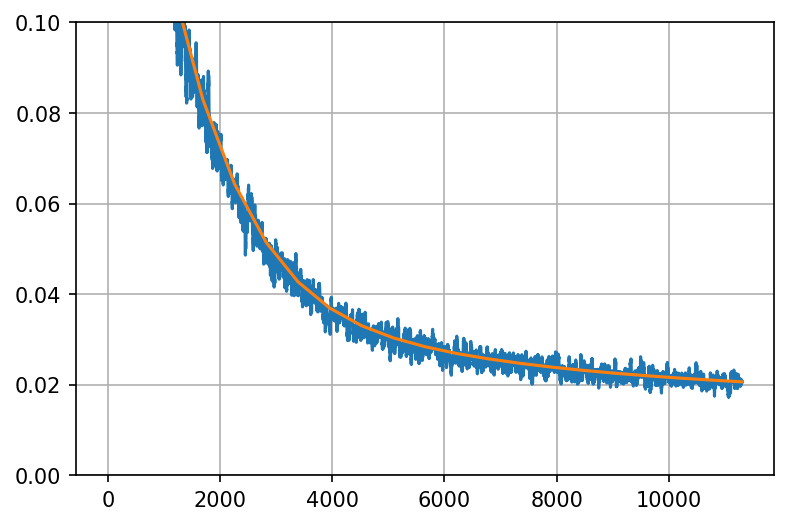

In [338]:
plt.figure(figsize=(6, 4), dpi=150)
plt.grid()
plt.ylim(0, 0.1)

print(len(losses_show) // len(val_losses))

plt.plot(range(len(losses_show)), losses_show)
plt.plot(range(len(losses_show) // len(val_losses), len(losses_show)+1, len(losses_show) // len(val_losses)), val_losses)
plt.show()

In [ ]:
# Test
